# Assignment 2

In [2]:
from __future__ import division, print_function, unicode_literals
import cv2
import xml.etree.ElementTree as ET
import cv2
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as tnf
from torch.autograd import Variable
from torchvision import datasets
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
plt.ion()
# Import other modules if required

resnet_input = 224 #size of resnet18 input images

In [3]:
# Choose your hyper-parameters using validation data
batch_size = 10
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9
use_gpu = False

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [4]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [4]:
def build_dataset():
    # Begin
    folders = ("train","test")

    train_classes = {
        'aeroplane' : [],
        'bicycle' : [],
        'bird' : [],
        'boat' : [],
        'bottle' : [],
        'bus' : [],
        'car' : [],
        'cat' : [],
        'chair' : [],
        'cow' : [],
        'diningtable' : [],
        'dog' : [],
        'horse' : [],
        'motorbike' : [],
        'person' : [],
        'pottedplant' : [],
        'sheep' : [],
        'sofa' : [],
        'train' : [],
        'tvmonitor' : []
    }
    test_classes = train_classes


    for dir in folders:
        raw_image = '../datasets/'+dir+'/JPEGImages/'
        anno_image = '../datasets/'+dir+'/Annotations/'
        train_dataset = '../datasets/train/final/'
        for anno_filename in os.listdir(anno_image):
            tree = 	ET.parse(anno_image+anno_filename)
            tmp = anno_filename.split('.')
            img_filename = tmp[0] + '.jpg'
            img = cv2.imread(raw_image+img_filename)
            root = tree.getroot()
            for i,object in enumerate(root.findall('object')):
                class1 = str(object.find('name').text)
                bndbox = object.find('bndbox')
                class1 = str(object[0].text)
                xmin = int(bndbox[0].text)
                ymin = int(bndbox[1].text)
                xmax = int(bndbox[2].text)
                ymax = int(bndbox[3].text)
                crop_img = img[ymin:ymax, xmin:xmax]
                if dir == 'train':
                    cv2.imwrite(train_dataset+class1+'/'+tmp[0]+'_'+str(i)+'.jpg', crop_img)
                    train_classes[class1].append(crop_img)
                # else:
                # 	test_classes[class1].append(crop_img)
            # break


In [5]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
#         build_dataset()
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.images, self.labels = [], []
        
        if train:
            root_dir = os.path.join(root_dir, 'train/final')
        else:
            root_dir = os.path.join(root_dir, 'test')
        
        label_list = os.listdir(root_dir)
        label_list.sort()
        print (label_list)
        for label in label_list:
            label_dir = os.path.join(root_dir, label)
            label_map = classes.index(label)
            # print(ord(label) - ord('A'), len(os.listdir(label_dir)))
            for image in os.listdir(label_dir):
                self.images += [os.path.join(label_dir, image)]
                self.labels += [label_map]
        
    def __len__(self):
        # Begin
        return len(self.images)
        
    def __getitem__(self, idx):
       # Begin
        img = Image.open(self.images[idx])
        imshow(np.asarray(img))
#         img = img.convert('RGB')
        print (img)
        img = self.transform(img) #img.convert('RGB')
        return (img, self.labels[idx])
    

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

[u'__background__', u'aeroplane', u'bicycle', u'bird', u'boat', u'bottle', u'bus', u'car', u'cat', u'chair', u'cow', u'diningtable', u'dog', u'horse', u'motorbike', u'person', u'pottedplant', u'sheep', u'sofa', u'train', u'tvmonitor']
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=97x148 at 0x7FE9CD216B90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=374x189 at 0x7FE9CD216B90>


TypeError: transpose received an invalid combination of arguments - got (int), but expected (int dim0, int dim1)

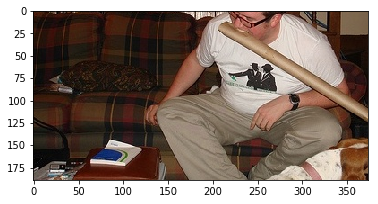

In [6]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.ToTensor(),
                                         transforms.RandomHorizontalFlip()])
train_dataset = voc_dataset(root_dir='../datasets/', train=True, transform=composed_transform) # Supply proper root_dir
# test_dataset = voc_dataset(root_dir='', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# # Let's look at one batch of train and test images
# def imshow(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
# print("Train images")
# imshow(torchvision.utils.make_grid(train_images))

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [6]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here

In [7]:
criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [8]:
def train():
    # Begin
    loss_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if (use_gpu):
                images = images.cuda()
                labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    
            
            running_loss += loss.data[0]
            
            if (i+1)%10 == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
        loss_store += [running_loss]

    plt.plot(loss_store)
    plt.title("Sum of Loss over subsequent epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Sum of loss")
    plt.show()

In [9]:
%time train()

TypeError: transpose received an invalid combination of arguments - got (int), but expected (int dim0, int dim1)

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [ ]:
def sliding_window():
    # Begin

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [ ]:
def non_maximum_supression(boxes,threshold = 0.3):
    # 

Test the trained model on the test dataset.

In [ ]:
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [ ]:
%time test(resnet18)